<br><br>
<font size='6'><b>Recurrent Neural Network
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        By Prof. Seungchul Lee<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

# 1. Recurrent Neural Network (RNN)
- RNNs are a family of neural networks for processing sequential data

## 1.1. Feedforward Network and Sequential Data

<br>
<img src="./image_files/sequence_layer.jpg" width = 400>
<br>

- Separate parameters for each value of the time index
    - Cannot share statistical strength across different time index

## 1.2. Structure of RNN

__ Recurrence __
- It is possible to use the __same__ transition function $f$ with the same parameters at every time step

<br>
<img src="./image_files/sequence_layer_dependv2.jpg" width = 370>
<br>

__ Hidden State __
- Lossy summary of the the past sequence of inputs up to $t$
- Keep some aspects of the past sequence with more precision than other aspects
- Network learns the function $f$
$$  h^{(t)} = f\left(h^{(t-1)}, x^{(t)}\right) $$
$$ f\left(h^{(t-1)}, x^{(t)}\right) = g\left(Wx_{t} + Uh_{t-1}\right) $$



<table style="border-style: hidden; border-collapse: collapse;" width = "96%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
<img src="./image_files/micro_view_rnn.jpg" width = 400>
        </td>
        <td width = 48%>
<img src="./image_files/recurrence_gif.gif" width = 400>
        </td>
    </tr>
</table>
<br>

__ Deep Recurrent Networks __
- Three blocks of parameters and associated transformation
    1. From the input to the hidden state (from green to yellow)
    2. From the previous hidden state to the next hidden state (from yellow to red)
    3. From the hidden state to the output (from red to blue)
    
<br>
<img src="./image_files/deep_RNN.PNG" width = 300>
<br>

## 1.3. Training RNN

__ Long-Term Dependencies __
- Gradients propagated over many stages tend to either vanish or explode
- Difficulty with long-term dependencies arises from the exponentially smaller weights given to long-term interactions

<br>
<img src="./image_files/vanishing_gradient.jpg" width = 550>
<br>

__ Long Short-Term Memory (LSTM) __
- Allow the network to __accumulate__ information over a long duration
- Once that information has been used, it might be use for the neural network to __forget__ the old state

<br>
<img src="./image_files/gates_lstm.png" width = 550>
<br>

__ Summary __
- Connect LSTM cell in recurrent manner
- Train parameters in LSTM cell

<br>
<img src="./image_files/RNN_Structure.png" width = 450>
<br>

<br>
<img src="./image_files/rnn_predict_edit.png" width = 450>
<br>

# 2. RNN with Tensorflow

- Will predict a future time signal
- Regression problem

## 2.1. Import Library

In [1]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt

## 2.2. Load Time Signal Data
- Import acceleration signal of rotation machinery

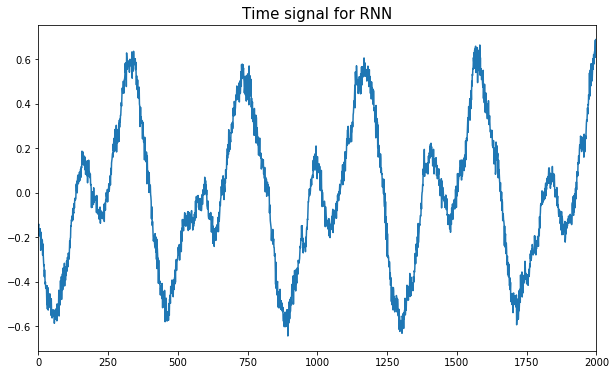

In [2]:
data =  cPickle.load(open('./data_files/rnn_time_signal.pkl', 'rb'))

plt.figure(figsize=(10,6))
plt.title('Time signal for RNN', fontsize=15)
plt.plot(data[0:2000])
plt.xlim(0,2000)
plt.show()

## 2.3. Define RNN Shape

<br>
<img src="./image_files/RNN_ac_edit.png" width = 650>
<br>

In [3]:
n_step = 25
n_input = 100
n_output = 100

## LSTM shape
n_hidden1 = 100
n_hidden2 = 100

## Fully connected
n_hidden3 = 100

## 2.4. Define Weights and Biases

__LSTM Cell__
- Do not need to define weights of lstm cell

__ Fully connected__
- Define parameters based on predefined layer size
- Initialize with normal distribution with $\mu = 0$ and $\sigma = 0.01$


In [4]:
weights = {
    'lstm1' : tf.Variable(tf.random_normal([n_hidden2, n_hidden3], stddev=0.01)),
    'lstm2' : tf.Variable(tf.random_normal([n_hidden3, n_output], stddev=0.01))
}

biases = {
    'lstm1' : tf.Variable(tf.random_normal([n_hidden3], stddev=0.01)),
    'lstm2' : tf.Variable(tf.random_normal([n_output], stddev=0.01))
}

x = tf.placeholder(tf.float32, [None, n_step, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

## 2.5. Build Model

__ Build RNN Network __
- First, define LSTM cell
```python
lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden)
```
- Second, compute hidden state (h) and lstm cell (c) with predefined lstm cell and input
```python
h, c = tf.nn.dynamic_rnn(lstm, input_tensor, dtype=tf.float32)
```

In [5]:
def net(x, weights, biases):
    with tf.variable_scope('rnn'):
        # Build RNN network
        with tf.variable_scope('lstm1'):
            #rnn_cell1 = tf.contrib.rnn.BasicRNNCell(n_hidden1)
            lstm1 = tf.contrib.rnn.BasicLSTMCell(n_hidden1)
            h1, c1 = tf.nn.dynamic_rnn(lstm1, x, dtype=tf.float32)
        with tf.variable_scope('lstm2'):
            #rnn_cell2 = tf.contrib.rnn.BasicRNNCell(n_hidden2)
            lstm2 = tf.contrib.rnn.BasicLSTMCell(n_hidden2)
            h2, c2 = tf.nn.dynamic_rnn(lstm2, h1, dtype=tf.float32)
            
        # Build classifier
        hidden = tf.matmul(h2[:, -1, :], weights['lstm1']) + biases['lstm1']
        hidden = tf.nn.relu(hidden)
        output = tf.matmul(hidden, weights['lstm2']) + biases['lstm2']
        return output

## 2.6. Define Cost, Initializer and Optimizer
__Loss__

- Regression : Squared loss
$$ \frac{1}{N} \sum_{i=1}^{N=100}  (\hat{y}^{(i)} - y^{(i)})^2$$

__Initializer__
- Initialize all the empty variables
    
__Optimizer__
- AdamOptimizer : The most popular optimizer

In [6]:
LR = 0.0001

pred = net(x, weights, biases)
loss = tf.square(y - pred)
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

## 2.7. Summary of Model

<br>
<img src="./image_files/cnn_summary of model.png" width = 500>
<br>

## 2.7. Define Configuration

- Define parameters for training RNN
     - n_iter : the number of training steps
     - n_prt : check loss for every n_prt iteration

In [7]:
n_iter = 5000
n_prt = 250
stride = 5

## 2.8. Optimize

In [8]:
# Run initialize
config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
sess = tf.Session(config=config)
sess.run(init)

for i in range(n_iter):
    train_x = data[i*stride:i*stride + n_step*n_input]
    train_x = train_x.reshape(n_step, n_input)
    train_x = train_x[np.newaxis, :]
    
    train_y = data[i*stride + n_step*n_input:i*stride + n_step*n_input + n_output]
    train_y = train_y[np.newaxis, :]
    
    sess.run(optm, feed_dict={x: train_x,  y: train_y})
    c = sess.run(loss, feed_dict={x: train_x,  y: train_y})
    if i % n_prt == 0:
        print ("Iter : {}".format(i))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.1861269623041153
Iter : 250
Cost : 0.19316987693309784
Iter : 500
Cost : 0.24163305759429932
Iter : 750
Cost : 0.18235526978969574
Iter : 1000
Cost : 0.23929165303707123
Iter : 1250
Cost : 0.2584276497364044
Iter : 1500
Cost : 0.19918107986450195
Iter : 1750
Cost : 0.15563027560710907
Iter : 2000
Cost : 0.14382842183113098
Iter : 2250
Cost : 0.1136963963508606
Iter : 2500
Cost : 0.011466247960925102
Iter : 2750
Cost : 0.0019118059426546097
Iter : 3000
Cost : 0.0031188037246465683
Iter : 3250
Cost : 0.01659834198653698
Iter : 3500
Cost : 0.008871719241142273
Iter : 3750
Cost : 0.010786447674036026
Iter : 4000
Cost : 0.005460628308355808
Iter : 4250
Cost : 0.0031475417781621218
Iter : 4500
Cost : 0.004526092670857906
Iter : 4750
Cost : 0.010671611875295639


## 2.9. Test
- Generate future time signal

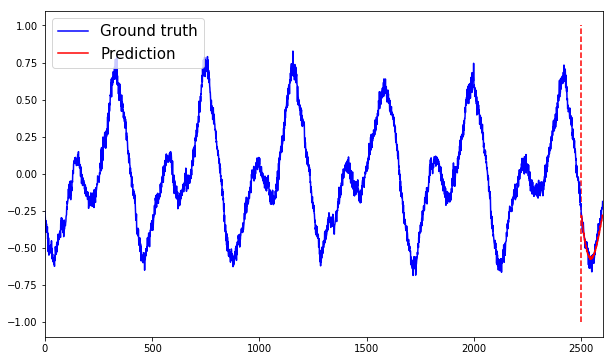

In [9]:
test_x = data[10000:10000 + n_step*n_input]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis, :]

ground_truth = data[10000:10000 + n_step*n_input + n_input]

test_pred = sess.run(pred, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_input), ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(n_step*n_input, n_step*n_input + n_input), test_pred.ravel(), 'r', label='Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.xlim(0, len(ground_truth))
plt.show()


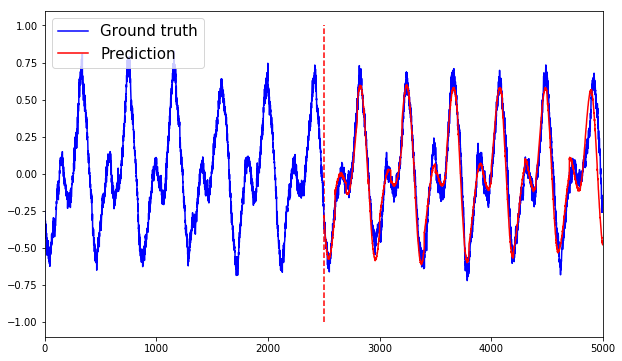

In [10]:
test_x = data[10000:10000 + n_step*n_input]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis, :]

ground_truth = data[10000:10000 + n_step*n_input + n_step*n_input]

gen_signal = []
for i in range(n_step):
    test_pred = sess.run(pred, feed_dict={x : test_x})
    gen_signal.append(test_pred.ravel())
    test_pred = test_pred[:, np.newaxis, :]
    
    test_x = test_x[:, 1:, :]
    test_x = np.concatenate([test_x, test_pred], axis=1)
    
gen_signal = np.concatenate(gen_signal)

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, n_step*n_input + n_step*n_input), ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(n_step*n_input,  n_step*n_input + n_step*n_input), gen_signal, 'r', label='Prediction')
plt.vlines(n_step*n_input, -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.xlim(0, len(ground_truth))
plt.show()

In [11]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>